# Preprocessing and Augmentation

In [2]:
import cv2
from skimage import morphology
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
path = "./images/training/"
path_test = "./testing/"
path_pg = "./images/playground/"
path_t = "./images/test/"

## Helper Functions

In [5]:
def rm_small(img, ms = 20, conn = 2):
    '''
    Removes small objects from image with size less than a given size.
    Mainly used for removing small dots and cleaning the image.
    
    img: black and white image from which small objects are to be removed
    ms: min size, objects with size < ms will be removed
    conn: connectivity, defines 4-connectivity or 8-connectivity
    
    return
    bin_im: black and white image with small objects removed
    '''
    mor = morphology.label(img)
    cleaned = morphology.remove_small_objects(mor,min_size = ms, connectivity = conn)
    
    bin_im = np.zeros((cleaned.shape))
    bin_im[cleaned>0] = 255
    bin_im = np.uint8(bin_im)
    return bin_im

In [6]:
def rot_image(img, angle):
    '''
    Rotate the image by the given angle.
    Used while vertically aligning the face.
    
    img: black and white image to be rotated
    angle: angle by which img is to be rotated
    
    return
    img_rot: rotated black and white image
    '''
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))
    return img_rot

In [7]:
def crop_rect(img, rect):
    '''
    Crops image based on a "rotated rectangle" (non-vertical rectangle)
    by first making the rectangle vertical and then croping it
    
    img: black and white image to be cropped
    rect: rotated rect based on which img is to be cropped
    
    return
    img_crop: the cropped image based on rect
    '''
    # rotate img
    img_rot = rot_image(img,rect[2])

    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    pts[pts < 0] = 0

    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1], pts[1][0]:pts[2][0]]
    return img_crop

In [8]:
def vert_count(img, batch=10):
    '''
    Gives the maximum number of white pixels
    by counting the white pixels column-wise
    and then taking the max value over all continuous batches
    
    This is used to check if the alignment of white objects is vertical or horizontal
    
    img: black and white image
    batch: number of adjacent columns to be clubbed
    
    return
    max count of white pixels, counted batch-wise
    '''
#   column-wise sum of all the rows
    col = np.sum(img, axis=0)
    
#   initial sum of a "batch"
    s = np.sum(col[:batch])
    
#   return the maximum sum of all the continuous batches over the "col-wise" sum array
    l = [s]
    for i in range(batch+1,col.shape[0]):
        s += col[i]
        s -= col[i-batch]
        l += [s]
    return max(l)

In [9]:
def count_eyes(img):
    '''
    Counts the number of white objects in the image.
    Used here to count the number of eyes.
    
    img: black and white image
    
    return
    count of number of white objects, in our case eyes
    '''
#   remove small white objects (if any) so that they do not get labeled
    img = rm_small(img,12)
    
#   again dilate the image to fill holes in eyes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    img = cv2.dilate(img,kernel,iterations = 3)
    img = rm_small(img,30)
    
#   return the number of labels as the eye count
    _,lbl = morphology.label(img, return_num=True)
    return lbl

## Preprocessing

In [10]:
vis = []
eye_vis = []

for i in range(1,8):
    c = i
    
    images = []
#   DEFINING READ/WRITE PATHS
    read = path
#     read = path_test
    
    write = path_pg
#     write = './images/v10/'
#     write = './images/test_v5/'
    
    mi = cv2.imread(read+str(c)+'.png',0)
    images.append(mi)
    
#   SEGMENTING FACIAL LANDMARKS (EYES, NOSE AND MOUTH)
    
    ret,mi2 = cv2.threshold(mi,20,255,cv2.THRESH_BINARY_INV)
    dil = rm_small(mi2,22)
    kernel = np.ones((1,1),np.uint8)
#     dil = cv2.dilate(dil,kernel,iterations = 1)
    dil = cv2.erode(dil,kernel,iterations = 3)
    
    images.append(dil)
    
    kernel = np.ones((4,4),np.uint8)
    dil_dot = cv2.morphologyEx(dil, cv2.MORPH_OPEN, kernel)
    dil_dot_i = ~dil_dot
    dil = np.bitwise_and(dil,dil_dot_i)
    dil = rm_small(dil,15)
    
    images.append(dil)

    
#   FACE MASK
    
    ret,white = cv2.threshold(mi,250,255,cv2.THRESH_BINARY)
    ret,black = cv2.threshold(mi,20,255,cv2.THRESH_BINARY_INV)
    
    mask = np.bitwise_or(black,white)
    mask = ~mask
    dil1 = rm_small(mask,150)
    dil1_i = ~dil1

#     kernel = np.ones((4,4),np.uint8)
#     dil1 = cv2.erode(dil1,kernel,iterations = 4)
#     dil1 = cv2.dilate(dil1,kernel,iterations = 4)
#     dil1 = cv2.dilate(dil1,kernel,iterations = 5)
#     dil1 = cv2.erode(dil1,kernel,iterations = 15)

    dil1_i = rm_small(dil1_i,1200)
    dil2 = ~dil1_i
    
#     kernel = np.ones((5,5),np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dil2 = cv2.erode(dil2,kernel,iterations = 3)
    dil2 = rm_small(dil2,10)
    face_mask = dil2
    
    images.append(face_mask)

    # cv2.imwrite(path2+str(c)+"_dil1.png",dil1)
    # cv2.imwrite(path2+str(c)+"_dil1_i.png",dil1_i)
    # cv2.imwrite(path2+str(c)+"_dil2.png",dil2)

    im = np.bitwise_and(dil,face_mask)
    im = np.uint8(im)

    
#   EYES

    eyes = np.bitwise_and(white,face_mask)
    eyes = rm_small(eyes,30)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    eyes = cv2.dilate(eyes,kernel,iterations = 3)
    eyes = cv2.erode(eyes,kernel,iterations = 3)
    
    eyes = rm_small(eyes,30)
    im = np.bitwise_or(im,eyes)
    
#     images.append(eyes)
    
#   MOUTH

    mouth = np.bitwise_and(black,face_mask)
#     mouth = ~mouth
#     mouth = cv2.morphologyEx(mouth, cv2.MORPH_GRADIENT, kernel)
#     mouth = cv2.dilate(mouth,kernel,iterations = 2)
#     mouth = cv2.morphologyEx(mouth, cv2.MORPH_GRADIENT, kernel)
    
    
#   NOISE REM / FINAL PROCESSING 
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    im = cv2.dilate(im,kernel,iterations = 2)
    im = cv2.erode(im,kernel,iterations = 2)
    
    im = cv2.morphologyEx(im, cv2.MORPH_GRADIENT, kernel)
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    
    images.append(im)
    
    
#   VERTICAL ALIGNMENT / FINDING VERTICAL ANGLE
    
    draw_im = face_mask
    _, contours, hierarchy = cv2.findContours(draw_im.copy() ,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = contours[0]
    
    draw = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
#     cv2.drawContours(draw, [contour], 0, (0,255,0), 2)
    
    rotrect = cv2.minAreaRect(contour)
    
#     box = cv2.boxPoints(rotrect)
#     box = np.int0(box)
#     cv2.drawContours(draw, [box], 0, (0,0,255), 2)
    
#     imc = crop_minAreaRect(im, rotrect)
    
    e1 = rot_image(eyes,rotrect[2])
    e2 = rot_image(eyes,rotrect[2]+90)
    
    n_eyes = count_eyes(e1)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
    e1 = cv2.dilate(e1,kernel,iterations = 5)
    e2 = cv2.dilate(e2,kernel,iterations = 5)
    eye_images = [e1, e2]
    
    angle = rotrect[2]
    if (n_eyes > 1):
        if vert_count(e1) > vert_count(e2):
            angle += 90
    else:
#         kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
#         e1 = cv2.dilate(e1,kernel,iterations = 3)
#         e2 = cv2.dilate(e1,kernel,iterations = 3)
        im1 = rot_image(im,angle)
        im2 = rot_image(im,angle+90)
        
        e1i = ~e1
        e2i = ~e2
        im1 = np.bitwise_and(e1i,im1)
        im2 = np.bitwise_and(e2i,im2)
        
        if vert_count(im1) < vert_count(im2):
            angle += 90
    
    
#   JOINING MOUTH AND REMOVING EXTRA DOTS 
    
    for i in range(10):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        im_wo = cv2.dilate(im,kernel,iterations=3)
        im = np.bitwise_or(im,mouth)
        im = cv2.bitwise_and(im_wo,im)
#     im = np.bitwise_or(im,mouth)
    
    
#   FINAL ROTATION

    im = rot_image(im,angle)
#     rect = cv2.minAreaRect(face_mask)
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)
#     cv2.drawContours(im,[box],0,(0,0,255),2)
    images.append(im)
    
    
#   RESIZE

    x,y,w,h = cv2.boundingRect(dil2)
    im_crop = im[y:y+h , x:x+w]
    im_crop = cv2.resize(im_crop,(256,256))
    
#     cv2.imwrite(write+str(c)+".png",im_crop)
    
    images.append(im_crop)
    vis.append(images)
    eye_vis.append(eye_images)

/home/navpun31/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


## Visualizations

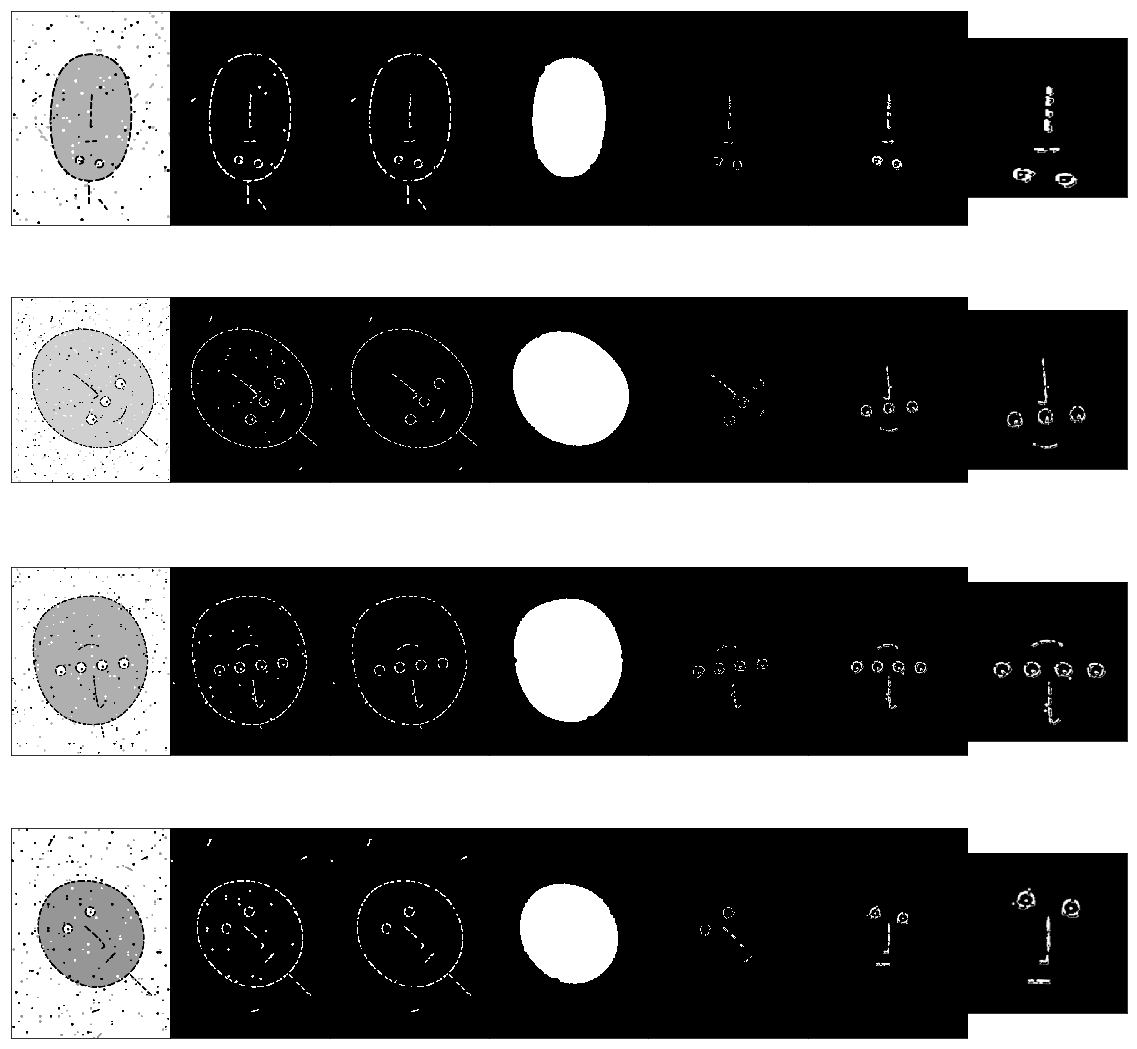

In [11]:
fig, ax = plt.subplots(4, len(vis[0]), figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0)
    
for i in range(4):
    for j in range(len(vis[0])):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        ax[i, j].imshow(cv2.cvtColor(vis[i][j],cv2.COLOR_GRAY2BGR), cmap="bone")
fig

In [12]:
images = vis[1]
face_mask = images[3]

draw_im = face_mask
_, contours, hierarchy = cv2.findContours(draw_im.copy() ,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]

draw = cv2.cvtColor(face_mask, cv2.COLOR_GRAY2BGR)
# cv2.drawContours(draw, [contour], 0, (0,255,0), 2)

rotrect = cv2.minAreaRect(contour)

box = cv2.boxPoints(rotrect)
box = np.int0(box)
cv2.drawContours(draw, [box], 0, (0,0,255), 2)
    
plot1 = []
plot1 = [draw]
plot1 += eye_vis[1]

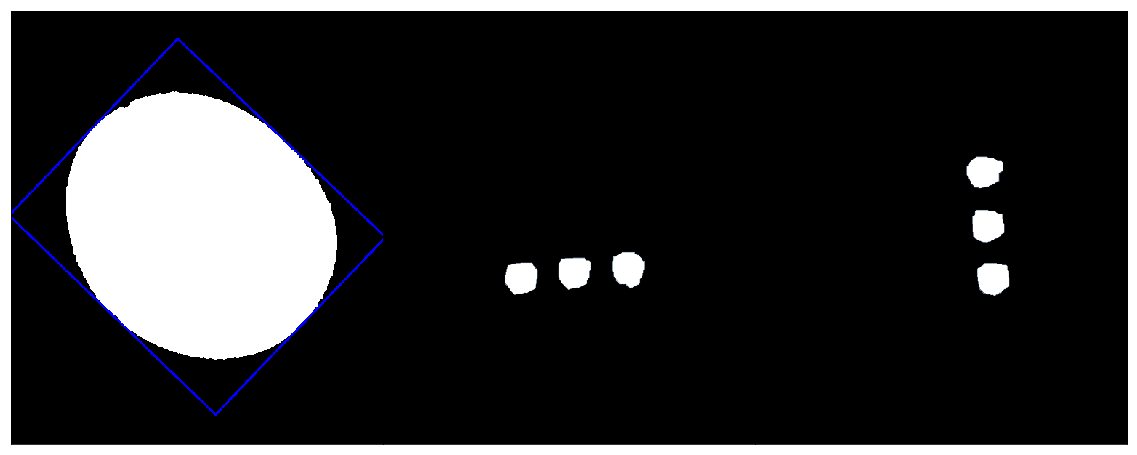

In [13]:
fig, ax = plt.subplots(1, len(plot1), figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0)
    
for i in range(len(plot1)):
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    ax[i].imshow(plot1[i], cmap="bone")
fig

## Rotations

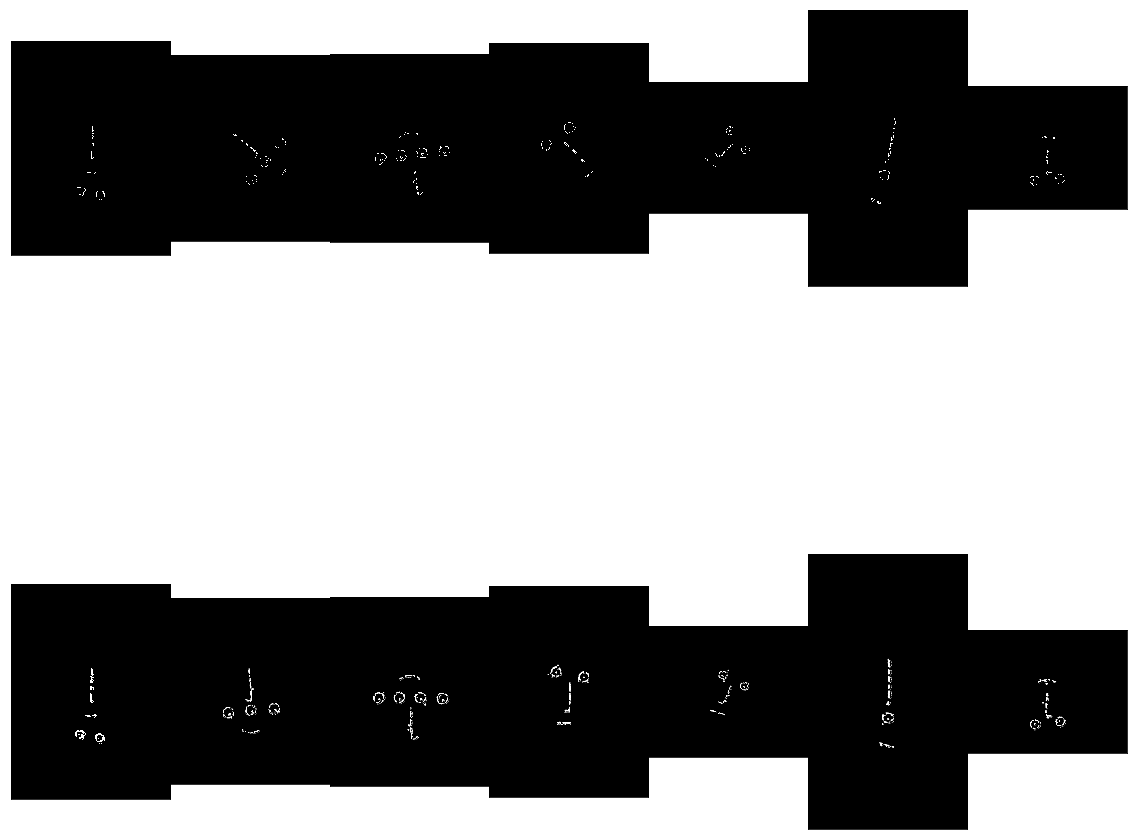

In [14]:
# ROTATIONS
fig, ax = plt.subplots(2, len(vis), figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0)
    
for i in range(len(vis)):
    ax[0,i].xaxis.set_major_locator(plt.NullLocator())
    ax[0,i].yaxis.set_major_locator(plt.NullLocator())
    ax[0,i].imshow(cv2.cvtColor(vis[i][4],cv2.COLOR_GRAY2BGR), cmap="bone")
    ax[1,i].xaxis.set_major_locator(plt.NullLocator())
    ax[1,i].yaxis.set_major_locator(plt.NullLocator())
    ax[1,i].imshow(cv2.cvtColor(vis[i][5],cv2.COLOR_GRAY2BGR), cmap="bone")
fig

## Augmentation

In [ ]:
# horizontally flipping the image (category remains the same)
for i in range(1,5001):
    c = i
    im = cv2.imread('./images/v11/'+str(c)+'.png',0)
    im = cv2.flip(im,1)
    cv2.imwrite('./images/v11/'+str(c+5000)+".png",im)

In [168]:
# find image ids of categories 1, 2 and 3
solve = pd.read_csv("./solution.csv")
ids = [solve['id'][i] for i in range(len(solve['id'])) if solve['category'][i] in [1,2,3]]

In [169]:
# contains categories
cat = list(solve['category'])
cat += cat

In [170]:
# contains count of the number of images used to train
cnt = 10001

# adds extra images to training data 
# vertically flipping categories 1, 2, and 3 give 6, 5 and 4 categories respectively
for i in ids:
    c = i
    read = './images/v11/'
    write = './images/v11/'
    
    im1 = cv2.imread(read+str(c)+'.png',0)
    im2 = cv2.imread(read+str(c+5000)+'.png',0)
    
    im1 = cv2.flip(im1,0)
    im2 = cv2.flip(im2,0)
    
    nid = 6
    if solve['category'][c-1] == 1:
        nid = 6
    elif solve['category'][c-1] == 2:
        nid = 5
    else:
        nid = 4
    
    cat += [nid]
    cat += [nid]
    
    cv2.imwrite(write+str(cnt)+".png",im1)
    cnt += 1
    cv2.imwrite(write+str(cnt)+".png",im2)
    cnt += 1

In [171]:
# new ids from 1 to cnt-1
nids = list(range(1,cnt))

print(len(cat))
print(len(nids))

14890
14890


In [172]:
# save the ids and category to csv
sol = {
    'id' : nids,
    'category' : cat
}
df = pd.DataFrame(sol)
df.to_csv('./images/v11.csv')

In [294]:
im1 = cv2.imread('./images/v6/'+str(4)+'.png',0)
im2 = cv2.imread('./images/v6/'+str(5004)+'.png',0)
im3 = cv2.imread('./images/v6/'+str(10001)+'.png',0)
im4 = cv2.imread('./images/v6/'+str(10002)+'.png',0)
images = [im1,im2,im3,im4]

/home/navpun31/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


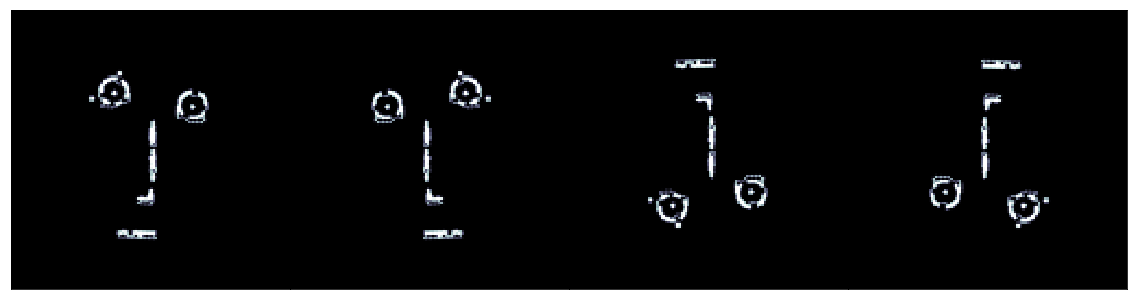

In [297]:
fig, ax = plt.subplots(1, len(images), figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0)
    
for i in range(len(images)):
    ax[i].xaxis.set_major_locator(plt.NullLocator())
    ax[i].yaxis.set_major_locator(plt.NullLocator())
    ax[i].imshow(images[i], cmap="bone")
fig

## Experiments

In [341]:
# # CIRCLE DETECTION
# cimg = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)

# circles = cv2.HoughCircles(im, cv2.HOUGH_GRADIENT, 1, 260, param1=30, param2=65, minRadius=0, maxRadius=0)
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     print(c, len(circles))
#     print(circles)
#     for i in circles[0,:]:
#         cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
#         cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

# edges = cv2.Canny(im,50,150,apertureSize = 3)

# # LINE DETECTION
# lines = cv2.HoughLines(edges,1,np.pi/180,200)
# if lines is not None:
#     for rho,theta in lines[0]:
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1000*(a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*(a))

#         cv2.line(cimg,(x1,y1),(x2,y2),(0,0,255),2)

In [ ]:
# for i in range(1,40001):
#     c = i
#     mi = cv2.imread(path_test+str(c)+'.png',0)
    
# #   ---------------
    
#     ret,mi2 = cv2.threshold(mi,20,255,cv2.THRESH_BINARY_INV)
#     dil = rm_small(mi2,22)
#     kernel = np.ones((1,1),np.uint8)
# #     dil = cv2.dilate(dil,kernel,iterations = 1)
#     dil = cv2.erode(dil,kernel,iterations = 3)
    
#     kernel = np.ones((4,4),np.uint8)
#     dil_dot = cv2.morphologyEx(dil, cv2.MORPH_OPEN, kernel)
#     dil = np.subtract(dil,dil_dot)
#     dil = rm_small(dil,15)
    
# #   ---------------- MASK
    
#     ret,white = cv2.threshold(mi,250,255,cv2.THRESH_BINARY)
#     ret,black = cv2.threshold(mi,20,255,cv2.THRESH_BINARY_INV)
    
#     mask = np.bitwise_or(black,white)
#     mask = ~mask
#     dil1 = rm_small(mask,150)
#     dil1_i = ~dil1

# #     kernel = np.ones((4,4),np.uint8)
# #     dil1 = cv2.erode(dil1,kernel,iterations = 4)
# #     dil1 = cv2.dilate(dil1,kernel,iterations = 4)
# #     dil1 = cv2.dilate(dil1,kernel,iterations = 5)
# #     dil1 = cv2.erode(dil1,kernel,iterations = 15)

#     dil1_i = rm_small(dil1_i,1200)
#     dil2 = ~dil1_i
    
# #     kernel = np.ones((5,5),np.uint8)
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#     dil2 = cv2.erode(dil2,kernel,iterations = 3)
#     dil2 = rm_small(dil2,10)
    
#     # cv2.imwrite(path2+str(c)+"_dil1.png",dil1)
#     # cv2.imwrite(path2+str(c)+"_dil1_i.png",dil1_i)
#     # cv2.imwrite(path2+str(c)+"_dil2.png",dil2)

#     im = np.bitwise_and(dil,dil2)
#     im = np.uint8(im)

# #     cv2.imwrite(path2+str(c)+"_im.png",dil2)
    
# #   ----------------- BOUNDING BOX

#     x,y,w,h = cv2.boundingRect(dil2)
#     im_crop = im[y:y+h , x:x+w]
# #     im_crop = np.array(im_crop)
#     im_crop = cv2.resize(im_crop,(128,128))
#     cv2.imwrite('./images/test_v1/'+str(c)+".png",im_crop)

/home/navpun31/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [174]:
# for i in range(1,40001):
#     c = i
# #     read = path
#     read = path_test
    
# #     write = path_pg
# #     write = './images/v11/'
#     write = './images/test_v10/'
    
#     mi = cv2.imread(read+str(c)+'.png',0)
    
# #   ---------------
    
#     ret,mi2 = cv2.threshold(mi,20,255,cv2.THRESH_BINARY_INV)
#     dil = rm_small(mi2,22)
#     kernel = np.ones((1,1),np.uint8)
# #     dil = cv2.dilate(dil,kernel,iterations = 1)
#     dil = cv2.erode(dil,kernel,iterations = 3)
    
#     kernel = np.ones((4,4),np.uint8)
#     dil_dot = cv2.morphologyEx(dil, cv2.MORPH_OPEN, kernel)
#     dil_dot_i = ~dil_dot
#     dil = np.bitwise_and(dil,dil_dot_i)
#     dil = rm_small(dil,15)
    
# #   ---------------- FACE MASK
    
#     ret,white = cv2.threshold(mi,250,255,cv2.THRESH_BINARY)
#     ret,black = cv2.threshold(mi,20,255,cv2.THRESH_BINARY_INV)
    
#     mask = np.bitwise_or(black,white)
#     mask = ~mask
#     dil1 = rm_small(mask,150)
#     dil1_i = ~dil1

# #     kernel = np.ones((4,4),np.uint8)
# #     dil1 = cv2.erode(dil1,kernel,iterations = 4)
# #     dil1 = cv2.dilate(dil1,kernel,iterations = 4)
# #     dil1 = cv2.dilate(dil1,kernel,iterations = 5)
# #     dil1 = cv2.erode(dil1,kernel,iterations = 15)

#     dil1_i = rm_small(dil1_i,1200)
#     dil2 = ~dil1_i
    
# #     kernel = np.ones((5,5),np.uint8)
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#     dil2 = cv2.erode(dil2,kernel,iterations = 3)
#     dil2 = rm_small(dil2,10)
#     face_mask = dil2
    
#     # cv2.imwrite(path2+str(c)+"_dil1.png",dil1)
#     # cv2.imwrite(path2+str(c)+"_dil1_i.png",dil1_i)
#     # cv2.imwrite(path2+str(c)+"_dil2.png",dil2)

#     im = np.bitwise_and(dil,face_mask)
#     im = np.uint8(im)
    
# #   ----------------- EYES

# #     eyes = np.bitwise_and(white,face_mask)
# #     eyes = rm_small(eyes,30)
    
# #     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# #     eyes = cv2.dilate(eyes,kernel,iterations = 3)
# #     eyes = cv2.erode(eyes,kernel,iterations = 3)
    
# #     eyes = rm_small(eyes,30)
# #     im = np.bitwise_or(im,eyes)
    
# #   ----------------- MOUTH

#     mouth = np.bitwise_and(black,face_mask)
# #     mouth = ~mouth
# #     mouth = cv2.morphologyEx(mouth, cv2.MORPH_GRADIENT, kernel)
# #     mouth = cv2.dilate(mouth,kernel,iterations = 2)
# #     mouth = cv2.morphologyEx(mouth, cv2.MORPH_GRADIENT, kernel)
    
# #   ----------------- NOISE REM
    
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
#     im = cv2.dilate(im,kernel,iterations = 2)
#     im = cv2.erode(im,kernel,iterations = 2)
    
#     im = cv2.morphologyEx(im, cv2.MORPH_GRADIENT, kernel)
#     im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    
# #   ----------------- VERTICAL ALIGNMENT
    
# #     draw_im = face_mask
# #     _, contours, hierarchy = cv2.findContours(draw_im.copy() ,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# #     contour = contours[0]
    
# #     draw = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
# # #     cv2.drawContours(draw, [contour], 0, (0,255,0), 2)
    
# #     rotrect = cv2.minAreaRect(contour)
    
# # #     box = cv2.boxPoints(rotrect)
# # #     box = np.int0(box)
# # #     cv2.drawContours(draw, [box], 0, (0,0,255), 2)
    
# # #     imc = crop_minAreaRect(im, rotrect)
    
# #     e1 = rot_image(eyes,rotrect[2])
# #     e2 = rot_image(eyes,rotrect[2]+90)
# #     n_eyes = count_eyes(e1)
    
# #     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
# #     e1 = cv2.dilate(e1,kernel,iterations = 5)
# #     e2 = cv2.dilate(e2,kernel,iterations = 5)
    
# #     angle = rotrect[2]
# #     if (n_eyes > 1):
# #         if vert_count(e1) > vert_count(e2):
# #             angle += 90
# #     else:
# # #         kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
# # #         e1 = cv2.dilate(e1,kernel,iterations = 3)
# # #         e2 = cv2.dilate(e1,kernel,iterations = 3)
# #         im1 = rot_image(im,angle)
# #         im2 = rot_image(im,angle+90)
        
# #         e1i = ~e1
# #         e2i = ~e2
# #         im1 = np.bitwise_and(e1i,im1)
# #         im2 = np.bitwise_and(e2i,im2)
        
# #         if vert_count(im1) < vert_count(im2):
# #             angle += 90
    
# #   ------------------- NOISE REM
    
# #     for i in range(10):
# #         kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
# #         im_wo = cv2.dilate(im,kernel,iterations=3)
# #         im = np.bitwise_or(im,mouth)
# #         im = cv2.bitwise_and(im_wo,im)
    
#     im = np.bitwise_or(im,mouth)

# #     im = rot_image(im,angle)
    
    
# #     rect = cv2.minAreaRect(face_mask)
# #     box = cv2.boxPoints(rect)
# #     box = np.int0(box)
# #     cv2.drawContours(im,[box],0,(0,0,255),2)
    
# #   ----------------- RESIZE

#     x,y,w,h = cv2.boundingRect(dil2)
#     im_crop = im[y:y+h , x:x+w]
#     im_crop = cv2.resize(im_crop,(256,256))
    
#     cv2.imwrite(write+str(c)+".png",im_crop)

/home/navpun31/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:127: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
